In [26]:
from tqdm import tqdm
import glob
import numpy as np
import multiprocessing as mp
from uuid import UUID
import lz4
from typing import List, Tuple, Dict, Union, Optional, Iterable
from joblib import Parallel, delayed

from pit30m.data.partitions import PreProcessPartition, GeoPartition, QueryBasePartition
from pit30m.camera import CamName
from pit30m import LogReader

%matplotlib inline
import matplotlib.pyplot as plt

In [32]:
with open("../pit30m/all_logs.txt", "r") as f:
    logs = f.readlines()
    logs = sorted([x.strip() for x in logs])

# logs = []
# for f in glob.glob("/home/julieta/pit30m_partitions/utm_poses_dense/to_hide/*"):
# print(logs)
#     logs.append(f.split("/")[-1][:-4])

logs = logs[:50]
print(logs)

['00682fa6-2183-4a0d-dcfe-bc38c448090f', '006ce26a-cd92-4b90-ec10-454da73ede13', '009334fa-acb9-4813-c60c-1916c83974c8', '00a05077-a8f6-4f08-ee38-c7bc4e885611', '0106abc2-b689-464a-cfe4-9f6a00089733', '017be362-c6cf-47fe-e317-fdcf128ce85a', '01959149-0840-4eba-e0a0-53c6b2bb0f84', '01c3ae4e-2bb6-4bd1-efc9-bfb16e4bd1e3', '01d09d4c-329a-4952-f2ed-555aa76dab2c', '01e21524-2e61-4ea6-cf98-164bcb2d29ab', '01e86404-c224-4b10-d12e-9e2144626b3b', '020465aa-b3f0-4b8e-c6af-b535078fe30c', '020829cb-e2a3-4160-df19-8bd4682f1115', '0209f084-2efb-4acf-f2ce-e8f8a58c8b06', '021286dc-5fe5-445f-e5fa-f875f2eb3c57', '024e8e83-7778-496f-e3c4-dfd7c0875d2d', '025c3909-7fe4-4817-e386-5d2de975363a', '025e793e-e8eb-4c6d-e074-accb77dbe4d3', '027a633e-c9d0-4340-fa28-50bf842e6d2c', '0281c09f-836a-4cfa-dcbd-77f1349b6b96', '0308a5d9-6e4c-498f-e7ef-c75e8ae721af', '0330dec6-1dbe-44d8-e139-723f2b7be005', '03359966-92d2-44d5-df29-3f391645f9ab', '03709ebf-bcce-43c5-dd63-9170b2a74836', '037e11f7-2300-47ad-e41d-9d87c2ec218f',

In [33]:
def maybe_get_sensor_index(log_reader: LogReader, sensor: str, partitions=None) -> Tuple[str, Optional[np.ndarray]]:
    """Try to fetch index from AWS, return None if it doesn't exist"""    
    try:
        if sensor == "LIDAR":
            index = log_reader.get_lidar_geo_index()
        elif sensor in CamName.__members__:
            index = log_reader.get_cam_geo_index(CamName[sensor.upper()], max_delta_s=0.2, partitions=partitions)
        else:
            raise ValueError(f"Unknown sensor {sensor}")
    except FileNotFoundError:
        index = None
    
    return log_reader.log_id, index
    

def get_sensor_indices(
    log_readers: Iterable[LogReader], sensor: str, partitions = None, 
) -> Tuple[Dict[UUID, np.ndarray], Dict[UUID, LogReader], Parallel]:
    """Get the indices that map poses to sensor observations"""
    pool = Parallel(n_jobs=mp.cpu_count(), verbose=1, batch_size=8)
    res = pool(delayed(maybe_get_sensor_index)(lr, sensor, partitions) for lr in log_readers)
    sensor_indices = {log_id: index for (log_id, index) in res}
    # log_readers = {log_id: lr for (log_id, lr) in zip(logs, log_readers)}
    return sensor_indices, pool

In [34]:
log_readers = {}
for logid in logs:
    # log_readers[logid] = LogReader(f"s3://pit30m/{logid}/", index_version=1)
    log_readers[logid] = LogReader(
        f"s3://pit30m/{logid}/", 
        index_version=2, 
        # partitions=[PreProcessPartition.VALID, GeoPartition.TRAIN],
        # partitions=[PreProcessPartition.VALID, GeoPartition.TEST, QueryBasePartition.QUERY],
    )

[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.


/home/julieta/miniconda3/envs/pit30m/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[Parallel(n_jobs=16)]: Done  50 out of  50 | elapsed:   34.2s finished
[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.


[Parallel(n_jobs=16)]: Done  50 out of  50 | elapsed:   32.9s finished
[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.


[Parallel(n_jobs=16)]: Done  50 out of  50 | elapsed:   28.8s finished


100%|██████████| 50/50 [00:00<00:00, 9698.71it/s]


4_743 poses included so far
4_743 poses included so far
4_743 poses included so far
9_233 poses included so far
9_233 poses included so far
26_312 poses included so far
37_108 poses included so far
37_108 poses included so far
37_108 poses included so far
37_108 poses included so far
54_359 poses included so far
54_359 poses included so far
60_516 poses included so far
60_516 poses included so far
65_683 poses included so far
70_728 poses included so far
70_728 poses included so far
90_938 poses included so far
115_532 poses included so far
115_532 poses included so far
121_658 poses included so far
121_658 poses included so far
121_658 poses included so far
125_136 poses included so far
125_324 poses included so far
125_324 poses included so far
134_921 poses included so far
134_921 poses included so far
134_921 poses included so far
144_348 poses included so far
148_671 poses included so far
158_341 poses included so far
158_341 poses included so far
158_341 poses included so far
168

100%|██████████| 50/50 [00:00<00:00, 9435.16it/s]


2_498 poses included so far
2_498 poses included so far
2_498 poses included so far
9_031 poses included so far
19_464 poses included so far
19_464 poses included so far
38_644 poses included so far
38_644 poses included so far
47_214 poses included so far
47_214 poses included so far
52_861 poses included so far
52_861 poses included so far
61_839 poses included so far
70_097 poses included so far
74_322 poses included so far
92_361 poses included so far
107_606 poses included so far
107_606 poses included so far
132_015 poses included so far
143_202 poses included so far
150_058 poses included so far
150_058 poses included so far
153_004 poses included so far
160_053 poses included so far
160_053 poses included so far
160_053 poses included so far
166_981 poses included so far
166_981 poses included so far
173_781 poses included so far
174_337 poses included so far
176_202 poses included so far
215_466 poses included so far
215_466 poses included so far
223_362 poses included so far


100%|██████████| 50/50 [00:00<00:00, 31920.12it/s]

0 poses included so far
0 poses included so far
0 poses included so far
5_354 poses included so far
5_354 poses included so far
5_513 poses included so far
5_513 poses included so far
5_513 poses included so far
5_513 poses included so far
25_293 poses included so far
25_293 poses included so far
25_293 poses included so far
25_293 poses included so far
25_293 poses included so far
25_293 poses included so far
25_293 poses included so far
25_293 poses included so far
25_293 poses included so far
25_293 poses included so far
25_293 poses included so far
25_293 poses included so far
25_293 poses included so far
28_288 poses included so far
30_582 poses included so far
34_116 poses included so far
34_116 poses included so far
36_341 poses included so far
36_341 poses included so far
36_341 poses included so far
40_342 poses included so far
40_342 poses included so far
43_710 poses included so far
43_710 poses included so far
43_710 poses included so far
43_710 poses included so far
43_710

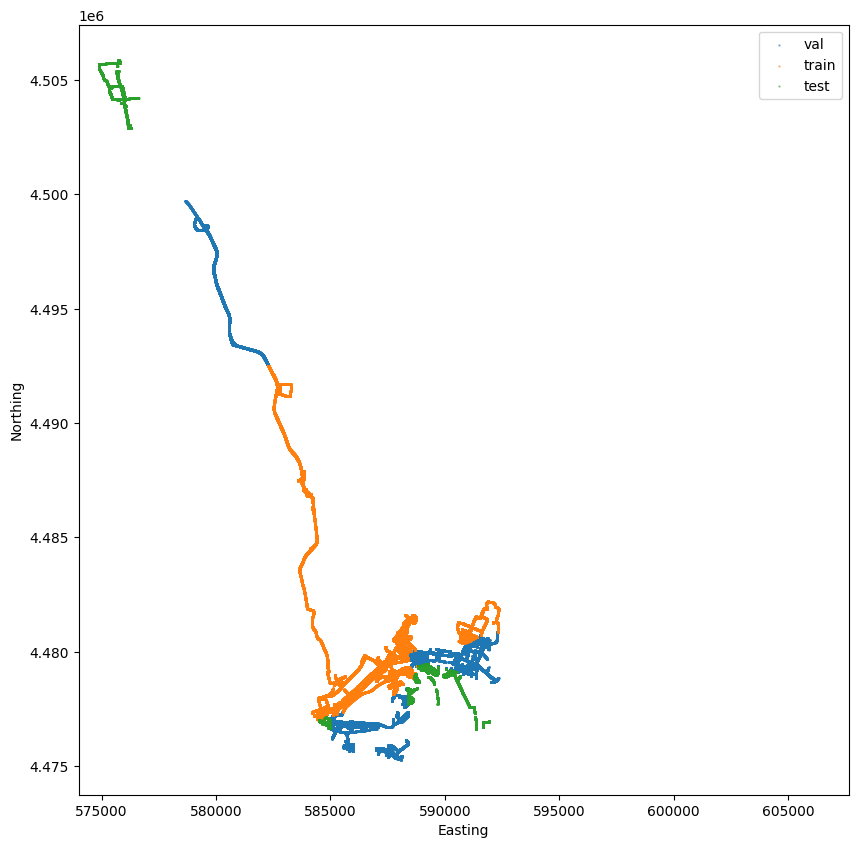

In [35]:
figsz = 20 // 2
fig = plt.figure(figsize=(figsz, figsz), dpi=100, facecolor='w', edgecolor='k')

# Load all the indices asynchronously
sensor_indices_TRAIN, pool = get_sensor_indices(
    log_readers.values(), 
    CamName.MIDDLE_FRONT_WIDE.name, 
    partitions=(PreProcessPartition.VALID, GeoPartition.TRAIN),
)

sensor_indices_VAL, pool = get_sensor_indices(
    log_readers.values(), 
    CamName.MIDDLE_FRONT_WIDE.name, 
    partitions=(PreProcessPartition.VALID, GeoPartition.VAL),
)

sensor_indices_TEST, pool = get_sensor_indices(
    log_readers.values(), 
    CamName.MIDDLE_FRONT_WIDE.name, 
    partitions=(PreProcessPartition.VALID, GeoPartition.TEST),
)


for label, sensor_indices in zip(["val", "train", "test"], [sensor_indices_VAL, sensor_indices_TRAIN, sensor_indices_TEST]):
    
    included = 0
    with_poses = []
    missing = []
    
    xs, ys = [], []
    for log_id, index in tqdm(sensor_indices.items()):

        # camera index
        if index is None:
            print(f"{log_id} has no index yet")
            missing.append(log_id)
            continue
        
        utm_present = index["utm_present"]
        x = index["utm_x"][utm_present]
        y = index["utm_y"][utm_present]
        
        xs.append(x)
        ys.append(y)
        
        included += len(x)
        print(f"{included:_} poses included so far")
    
    x = np.concatenate(xs)
    y = np.concatenate(ys)
    sc = plt.scatter(x, y, s=0.5, alpha=0.5, label=label)

plt.axis("square")
plt.xlabel("Easting")
plt.ylabel("Northing")
plt.legend()
print(f"Total included: {included:_}")
print(f"Total with poses: {len(with_poses)}")
print(with_poses)
print(missing)